In [47]:
import requests
import re
from bs4 import BeautifulSoup

# Задание 1


Дано: [Сайт Библио-Глобуса](https://www.biblio-globus.ru)

Если сайт Библио-Глобуса помре, то можно [сайт Читай-Города](https://www.chitai-gorod.ru)

Задание: средствами парсинга ответить на список вопросов ниже


1) Какова в среднем длина (в страницах) книги из категории классическая литература в ассортименте магазина?

2) Какое у этих книг распределение цен? (попробуйте нарисовать [гистограмму](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)

3) Как соотносятся средние цены книг по Python, Машинному обучению и C++ ? (поясните, как именно вы доставали такие книги :), то есть "я буду доставать книги вот так, потому что...")


In [170]:
"""Сначала напишем несколько простых функций, которые в дальнейшем потребуются при анализе страниц сайта Библио-Глобуса"""

def get_book_id_from_book_link(a):
    """Возвращает id книги из ссылки на нее"""
    return a['href'].split('/')[2]

def get_page_number_from_paginator_link(a):
    """Возвращает целочисленный номер страницы из ссылки на эту страницу в блоке паджинации"""
    match = re.search(r'page=(\d+)', a['href'])
    if match:
        return int(match.group(1))
    else:
        # print(f'При поиске номера страницы в ссылке {a} не был найден номер страницы, удовлетворяющий условиям. Вернулся 0')
        return 0

def get_price_from_price_block_tag(price_block_tag, page_url):
    """Возвращает целочисленную цену книги из html-тега, внутри которого записана цена"""
    matches = re.findall(r'\d+', price_block_tag.string)
    if len(matches) > 1: 
        print(f'При поиске цены книги по url={page_url} было найдено {len(matches)} значений цены в одном блоке с ценой. Будет сохранена первая')
    if len(matches) > 0: 
        return int(matches[0])
    else: 
        return None

In [171]:
"""Теперь с использованием паттерна PageObject, применяемого в автоматизированном UI-тестировании напишем классы для страниц разных типов,
которые позволят нам получать данные с этих страниц"""

class Page:
    """Базовый класс для страниц, реализующий ее загрузку и парсинг с помощью BeautifulSoup"""
    def get_soup(self):
        return self._soup
    def _load_page(self):
        response = requests.get(self._url)
        self._soup = BeautifulSoup(response.text, 'html.parser')
        
class BooksPage(Page):
    """Базовый класс для страницы с книгами в категории или в результатах поиска. Реализует основные методы получения информации о книгах на странице:
    списка их идентификаторов, онлайн и оффлайн ценах, а также о номере последней страницы в результатах"""
    def get_book_ids(self):
        return tuple(map(get_book_id_from_book_link, self._soup.css.select('div.product a.img_link')))
    
    def get_books_online_and_store_prices(self):
        book_prices = []
        book_price_areas = self.get_soup().css.select('div.prices_item')
        for book_price_area in book_price_areas:
            price_spans = book_price_area.css.select('div.price_item_block span')
            if len(price_spans) != 2: 
                print(f'При поиске цены книг на очередной странице с книгами в категории (url={self._url}) было найдено {len(price_spans)} блоков '
                      f'с ценами для одной книги, хотя ожидалось 2. Цены для данной книги определены не будут')
                book_prices.append((None, None))
            else:
                book_prices.append((get_price_from_price_block_tag(price_spans[0], self._url), get_price_from_price_block_tag(price_spans[1], self._url))) 
        return book_prices
    
    def get_max_page_number(self):
        return max(map(get_page_number_from_paginator_link, self._soup.css.select('ul.pagination a.page-link')))
    
    
class CategoryBooksPage(BooksPage):
    """Класс для страницы с книгами в заданной категории. Реализует особенности загрузки такой страницы"""
    def __init__(self, category_id, page_number:int):
        self._url = f'https://www.biblio-globus.ru/catalog/category?id={category_id}&page={page_number}&sort=0&instock=&isdiscount='
        self._load_page()
        
class FoundBooksPage(BooksPage):
    """Класс для страницы с книгами, найденными с использованием поиска"""
    def __init__(self, query:str, page_number:int):
        books_category_id = 5
        self._url = f'https://www.biblio-globus.ru/search?query={query}&page={page_number}&sort=0&instock=&cat={books_category_id}&isdiscount='
        self._load_page()
    
class BookPage(Page):
    """Класс для страницы с одной книгой. Реализует получение основной информации о книге: онлайн и оффлайн цены, а также количества страниц"""
    def __init__(self, book_id):
        self._url = f'https://www.biblio-globus.ru/product/{book_id}'
        self._load_page()
    
    def _get_price(self, price_span):
        return get_price_from_price_block_tag(price_span, self._url)
    
    def get_online_and_store_prices(self):
        price_spans = self._soup.css.select('div span.price_new')
        if len(price_spans) != 2: 
            print(f'При поиске цены книги по url={self._url} было найдено {len(price_spans)} блоков с ценами, хотя ожидалось 2. Цены для данной книги определены не будут')
            return None, None
        return self._get_price(price_spans[0]), self._get_price(price_spans[1]) 

    def get_page_count(self):
        caption_b = self._soup.find('b', string='Количество страниц:')
        if not caption_b:
            print(f'При поиске количества страниц книги по url={self._url} не было найдено расположение заголовка "Количество страниц". Возвращено None')
            return None
        price_td = caption_b.findNext('td')
        if not price_td:
            print(f'При поиске количества страниц книги по url={self._url} не был найден блок с количеством. Возвращено None')
            return None
        matches = re.findall(r'\d+', price_td.string)
        if len(matches) > 1: 
            print(f'При поиске количества страниц книги по url={self._url} было найдено {len(matches)} значений для количества страниц. Будет сохранено первое')
        if len(matches) > 0: 
            return int(matches[0])
        else: 
            return None
        

In [382]:
"""1) Какова в среднем длина (в страницах) книги из категории классическая литература в ассортименте магазина?"""
"""2) Какое у этих книг распределение цен? (попробуйте нарисовать гистограмму)"""

# загрузим цены и длины страниц всех книг в категории "классическая литература"
# для этого пройдем по всем страницам с книгами в категории, перейдем в каждую книгу
# на каждой страницы и возьмем оттуда цены и количество страниц (количество страниц
# есть только на странице книги, поэтому нельзя ограничиться только страницами с книгами в категории)
#начнем с первой страницы с книгами в этой категории: https://www.biblio-globus.ru/catalog/category?id=226&page=1&sort=0&instock=&isdiscount=

category_id = 226 #ИД категории "Классическая литература"
results1 = []


cat_page = CategoryBooksPage(category_id, 1)
max_page_number = cat_page.get_max_page_number()
    
for page_number in range(1,max_page_number+1): 
    cat_page = CategoryBooksPage(category_id, page_number)
    for book_id in cat_page.get_book_ids():
        book_page = BookPage(book_id)
        prices = book_page.get_online_and_store_prices()
        page_count = book_page.get_page_count()
        results1.append( {'book_id':book_id, 'page_count': page_count, 'price_online': prices[0], 'price_offline':prices[1]} )

При поиске количества страниц книги по url=https://www.biblio-globus.ru/product/10631746 не было найдено расположение заголовка "Количество страниц". Возвращено None


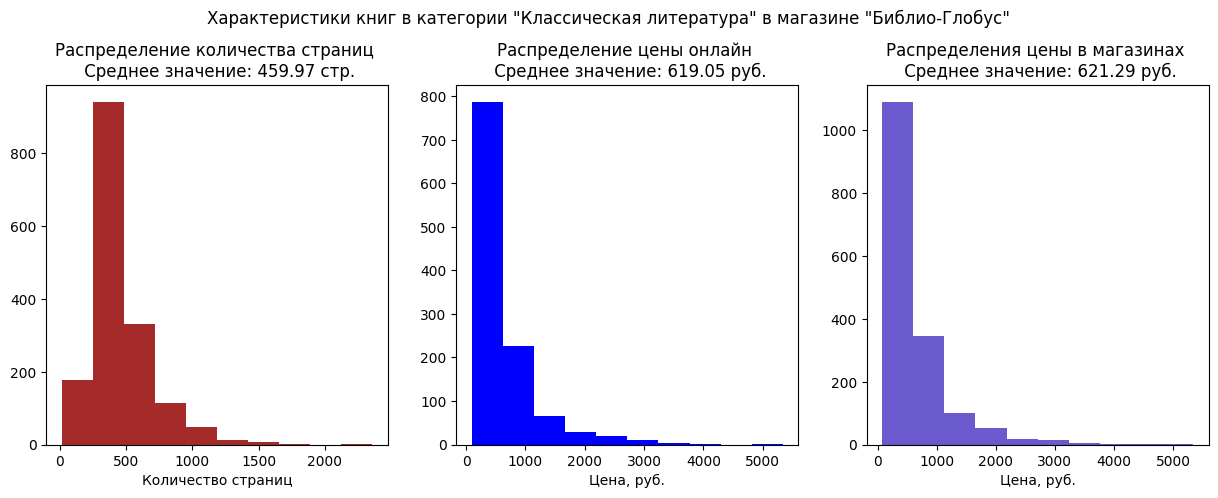

In [383]:
# для удобства обработки загрузим полученный словарь в DataFrame Pandas и нарисуем гистограммы для количества страниц, цены онлайн 
# и цены оффлайн, и также отобразим в их заголовке искомые средние значения  

from pandas import DataFrame
import matplotlib.pyplot as plt

df1 = DataFrame(results1)

plt.figure(figsize=(15,5))
plt.suptitle('Характеристики книг в категории "Классическая литература" в магазине "Библио-Глобус"')
plt.subplots_adjust(top=0.83)

plt.subplot(1,3,1)
plt.hist(df1['page_count'], color='brown')
plt.title(f'Распределение количества страниц \n Среднее значение:{df1["page_count"].mean():7.2f} стр.')
plt.xlabel('Количество страниц')

plt.subplot(1,3,2)
plt.hist(df1['price_online'], color='blue')
plt.title(f'Распределение цены онлайн \n Среднее значение:{df1["price_online"].mean():7.2f} руб.')
plt.xlabel('Цена, руб.')

plt.subplot(1,3,3)
plt.hist(df1['price_offline'], color='slateblue')
plt.title(f'Распределения цены в магазинах \n Среднее значение:{df1["price_offline"].mean():7.2f} руб.')
plt.xlabel('Цена, руб.')

plt.show()

In [376]:
"""3) Как соотносятся средние цены книг по Python, Машинному обучению и C++ ? 
(поясните, как именно вы доставали такие книги :), то есть "я буду доставать книги вот так, потому что...")"""

# Для поиска книг по Pyhon, Машинному обучению, C++ и т.д. можно использовать поиск на сайте, результаты которого 
# выводятся в том же виде, что и списки книг в категориях, которые анализировались выше. Для отображения результатов 
# поиска на сайте используется страница с URL вида https://www.biblio-globus.ru/search?query=python&page=1&sort=0&instock=&cat=5&isdiscount=,
# где легко увидеть сам поисковый запрос (например, 'python'), номер страницы с результатами поиска и номер категории товаров, где 5 - это книги.
# Таким образом, для поиска книг по указанным выше темам мы обойдем все страницы указанного вида и соберем информацию обо всех найденных книгах по теме.

# Т.к. поиск по C++ на сайте Библио-Глобуса почему-то не работает, заменим C++ на JavaScript

# Поскольку в данном задании количество страниц нас не интересует, мы не будем переходить на страницу каждой книги. Вместо этого мы соберем
# цены книг непосредственно со страниц с результатами поиска

# а чтобы увидеть, насколько дороже покупать книги по ИТ, чем книги детям, добавим в набор тем Чуковского) 

results2 = []
queries = ['python', 'javascript', 'машинное обучение', 'Чуковский']

for query in queries:
    books_page = FoundBooksPage(query,1)
    max_page_number = books_page.get_max_page_number()
    
    for page_number in range(1, max_page_number + 1): 
        books_page = FoundBooksPage(query,page_number)
        for price_pair in books_page.get_books_online_and_store_prices():
            results2.append({'query':query, 'price_online': price_pair[0], 'price_offline':price_pair[1]})

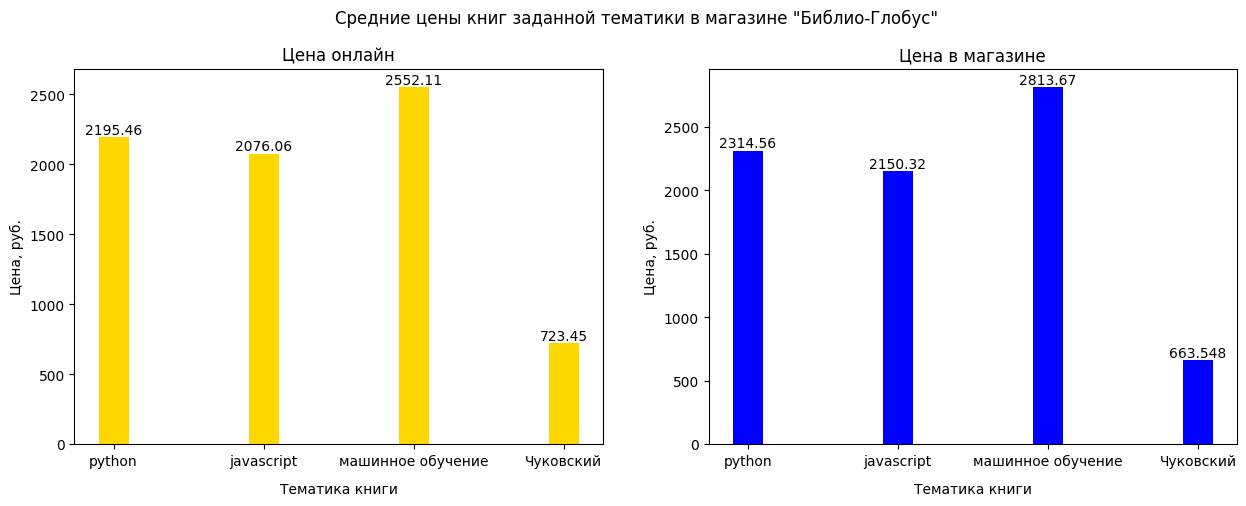

In [378]:
# для удобства обработки также загрузим полученный словарь в DataFrame Pandas и отобразим средние значения цены 
# для книг, заданной тематики на диаграмме   

df2 = DataFrame(results2)
res = [[],[],[]]
for name, group in df2.groupby('query', sort=False):
    res[0].append(name)
    res[1].append(group['price_online'].mean())
    res[2].append(group['price_offline'].mean())

plt.figure(figsize=(15,5))
plt.suptitle('Средние цены книг заданной тематики в магазине "Библио-Глобус"')
plt.subplots_adjust(top=0.86)

plt.subplot(1,2,1)
bars = plt.bar(res[0], res[1], color='gold', width=0.2)
plt.bar_label(bars)
plt.title('Цена онлайн')
plt.xlabel('Тематика книги', labelpad=10)
plt.ylabel('Цена, руб.')

plt.subplot(1,2,2)
bars = plt.bar(res[0], res[2], color='blue', width=0.2)
plt.bar_label(bars)
plt.title('Цена в магазине')
plt.xlabel('Тематика книги', labelpad=10)
plt.ylabel('Цена, руб.')

plt.show()

# Задание 2 про перевод из camel_case'a в snake_case

Дано произвольное название, написанное в camelCase, перевести его в snake_case

In [ ]:
import re
v = 'camelCaseVar'

#должно превратиться в camel_case_var

## Задание 3, Про время 

Вовочка подготовил одно очень важное письмо, но везде указал неправильное время. 
Поэтому нужно заменить все вхождения времени на строку (TBD). Время — это строка вида HH:MM:SS или HH:MM, в которой HH — число от 00 до 23, а MM и SS — число от 00 до 59.

Ввод:

    Уважаемые! Если вы к 09:00 не вернёте 
    чемодан, то уже в 09:00:01 я за себя не отвечаю. 
    PS. С отношением 25:50 всё нормально!
    
Вывод:

    Уважаемые! Если вы к (TBD) не вернёте 
    чемодан, то уже в (TBD) я за себя не отвечаю. 
    PS. С отношением 25:50 всё нормально!

In [2]:
inp = """Уважаемые! Если вы к 09:00 не вернёте 
чемодан, то уже в 09:00:01 я за себя не отвечаю. 
PS. С отношением 25:50 всё нормально!"""

# Задание 4 Про отчетность 

Владимиру потребовалось срочно запутать финансовую документацию. Но так, чтобы это было обратимо. 
Он не придумал ничего лучше, чем заменить каждое целое число (непрерывную последовательность цифр) на его куб. Помогите ему.

Ввод:

    Было закуплено 12 единиц техники 
    по 410.37 рублей.
    
Вывод:

    Было закуплено 1728 единиц техники 
    по 68921000.50653 рублей.

In [4]:
# Для решения вероятно в функцию sub надо будет пихать другую функцию. Пример "как это делать"

import re

def convert_func(matchobj):
    m =  matchobj.group(0)
    map = {'7': 'seven',
           '8': 'eight',
           '9': 'nine'}
    return map[m]

line = "7 ate 9"
new_line =  re.sub("[7-9]", convert_func, line)

new_line

'seven ate nine'

# Задание 5. Про NumPy и SVD

[Почитать про SVD - 1](http://timbaumann.info/svd-image-compression-demo/)

Сожмите картинку во всех трех каналах с помощью SVD (R,G и B) и оцените, сколько нужно компонент, чтобы получилось вменяемое качество. А сколько мы при этом экономим места?

[Как жать все 3 канала](https://www.kaggle.com/code/paulbacher/practical-applications-to-svd-on-rgb-images/notebook)

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

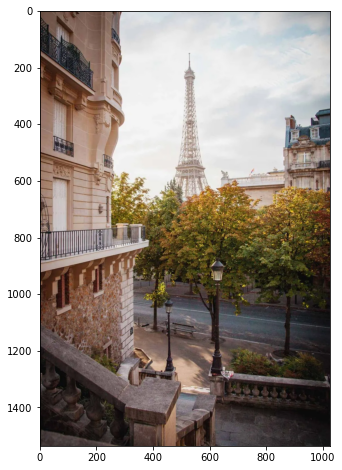

In [14]:
image = Image.open('Avenue-de-Camoens-Paris-Eiffel-Tower.png')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()